In [1]:
# Import libraries
library(data.table)    # Data manipulate
library(caret)         # ML toolkit
library(mlr)           # ML toolkit
library(pROC)          # AUC, ROC
library(rpart)         # Decision tree
library(randomForest)  # Bagging and RF
library(gbm)           # Boosting tree
library(fastDummies)
library(dplyr)
library(MASS)
library(tree)
library(e1071)

Loading required package: ggplot2

Loading required package: lattice

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.


Attaching package: 'mlr'


The following object is masked from 'package:caret':

    train


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


Loaded gbm 2.1.8


Attaching package: 'dplyr'


The following object is masked from 'package:randomForest':

    combine


The following objects are masked from 'package:data.table':

    between, first, last


The 

# 1. Import Data & Prepare Data

In [2]:
# Read the provided data
data <- read.csv('credit_default_train.csv')

In [3]:
head(data)

,cust_id,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,18895,70000,1,3,2,34,0,0,0,0,⋯,25559,26134,26715,1700,1500,2000,1000,1000,2000,0
2,25102,390000,2,2,2,26,2,2,2,0,⋯,140387,128112,115514,5000,3000,5000,4548,4100,3300,0
3,28867,60000,1,1,2,27,0,0,0,0,⋯,26038,28607,27997,1378,1406,3000,3000,0,923,1
4,1842,140000,2,2,1,55,0,0,0,0,⋯,72391,61298,62193,4200,2822,2336,2588,2250,2491,0
5,3371,50000,1,1,2,29,2,2,2,0,⋯,1047,0,0,3000,0,1000,0,0,0,1
6,29925,20000,1,2,2,37,0,0,0,0,⋯,19105,19609,19283,1700,1600,1200,1000,900,1000,0


In [4]:
# Train test spliting
set.seed(123)
train_idx <- createDataPartition(data$default.payment.next.month, p=.7, list=FALSE)

#Trainset
train <- data[train_idx, ]

#Testset
test <- data[-train_idx, ]

###    1.1 Preprocessing train set

In [5]:
iv_vars <- colnames(train)[2:(ncol(train)-1)]
monetary_vars <- colnames(train)[13:(ncol(train)-1)]
monetary_vars <- append(monetary_vars, "LIMIT_BAL")
pay_vars <- colnames(train)[7:12]

Missing Values

In [6]:
#Check missing values
apply(is.na(train[iv_vars]), 2, sum)

LIMIT_BAL       SEX EDUCATION  MARRIAGE       AGE     PAY_0     PAY_2     PAY_3 
      143       114       147       120       160       133       150       152 
    PAY_4     PAY_5     PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5 
      147       131       145       136       141       124       116       132 
BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6 
      151       141       128       149       127       133       139

In [7]:
#Replace the missing monetary amounts with the mean


for (v in monetary_vars) { train[is.na(train[,v]), v] <- mean(train[,v], na.rm = TRUE) } 

#replace missing payment type with mode by creating a function 
#Reference: https://www.tutorialspoint.com/r/r_mean_median_mode.htm#:~:text=R%20does%20not%20have%20a,the%20mode%20value%20as%20output.

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

for (v in pay_vars) { train[is.na(train[,v]), v] <- getmode(train[,v]) } 


#Replace missing age with average age

meanage <- mean(train[,'AGE'], na.rm = TRUE)

train[is.na(train[,'AGE']), 'AGE'] <- meanage

# Replace missing gender with 'Missing'
train[is.na(train[,'SEX']), 'SEX'] <- "Missing_Gender"


# Replace missing values in eduation and fix the incorrect categories
train$EDUCATION <- ifelse(is.na(train[,'EDUCATION']) | train$EDUCATION < 1| train$EDUCATION > 4, 4, train$EDUCATION)

# Replace missing values in marriage and fix the incorrect categories
train$MARRIAGE <- ifelse(is.na(train[,'MARRIAGE']) | train$MARRIAGE < 1, 3, train$MARRIAGE)


In [8]:
sum(is.na(train))

[1] 0

Replace encoded categories

In [9]:
#Replace the encoded value of gender with terms
train$SEX <- ifelse(train$SEX == 1, 'Male', train$SEX)
train$SEX <- ifelse(train$SEX == 2, 'Female', train$SEX)


#Replace the encoded value of education with terms
train[train$EDUCATION == 1, 'EDUCATION'] <- "GradSchool"
train[train$EDUCATION == 2, 'EDUCATION'] <- "University"
train[train$EDUCATION == 3, 'EDUCATION'] <- "HighSchool"
train[train$EDUCATION == 4, 'EDUCATION'] <- "Other"


#Replace the encoded value of marriage with terms
train[train$MARRIAGE == 1, 'MARRIAGE'] <- "Married"
train[train$MARRIAGE == 2, 'MARRIAGE'] <- "Single"
train[train$MARRIAGE == 3, 'MARRIAGE'] <- "Others"

#Create three age groups

train[train$AGE >= 60, 'AGE'] <- "Senior"
train[((train$AGE >= 20) & (train$AGE < 40)), 'AGE'] <- "YoungAdult"
train[(train$AGE >= 40) & (train$AGE < 60), 'AGE'] <- "MiddleAge"



###    1.2 Preprocessing test set

Missing Values

In [10]:
#Check missing values
apply(is.na(test[iv_vars]), 2, sum)

LIMIT_BAL       SEX EDUCATION  MARRIAGE       AGE     PAY_0     PAY_2     PAY_3 
       59        47        52        50        54        62        69        65 
    PAY_4     PAY_5     PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5 
       52        54        58        49        68        51        49        49 
BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6 
       46        63        56        63        70        46        57

In [11]:
#All missing values in the test set will be replaced with metrics obtained from the train set

#Replace the missing monetary amounts with the mean
for (v in monetary_vars) { test[is.na(test[,v]), v] <- mean(train[,v], na.rm = TRUE) } 

#replace missing payment type with mode by creating a function 
#Reference: https://www.tutorialspoint.com/r/r_mean_median_mode.htm#:~:text=R%20does%20not%20have%20a,the%20mode%20value%20as%20output.

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

for (v in pay_vars) { test[is.na(test[,v]), v] <- getmode(train[,v]) } 


#Replace missing age with average age
test[is.na(test[,'AGE']), 'AGE'] <- meanage

# Replace missing gender with 'Missing'
test[is.na(test[,'SEX']), 'SEX'] <- "Missing_Gender"


# Replace missing values in eduation and fix the incorrect categories
test$EDUCATION <- ifelse(is.na(test[,'EDUCATION']) | test$EDUCATION < 1| test$EDUCATION > 4, 4, test$EDUCATION)

# Replace missing values in marriage and fix the incorrect categories
test$MARRIAGE <- ifelse(is.na(test[,'MARRIAGE']) | test$MARRIAGE < 1, 3, test$MARRIAGE)


In [12]:
sum(is.na(test))

[1] 0

Replace encoded categories

In [13]:
#Replace the encoded value of gender with terms
test$SEX <- ifelse(test$SEX == 1, 'Male', test$SEX)
test$SEX <- ifelse(test$SEX == 2, 'Female', test$SEX)


#Replace the encoded value of education with terms
test[test$EDUCATION == 1, 'EDUCATION'] <- "GradSchool"
test[test$EDUCATION == 2, 'EDUCATION'] <- "University"
test[test$EDUCATION == 3, 'EDUCATION'] <- "HighSchool"
test[test$EDUCATION == 4, 'EDUCATION'] <- "Other"


#Replace the encoded value of marriage with terms
test[test$MARRIAGE == 1, 'MARRIAGE'] <- "Married"
test[test$MARRIAGE == 2, 'MARRIAGE'] <- "Single"
test[test$MARRIAGE == 3, 'MARRIAGE'] <- "Others"

#Create three age groups

test[test$AGE >= 60, 'AGE'] <- "Senior"
test[((test$AGE >= 20) & (test$AGE < 40)), 'AGE'] <- "YoungAdult"
test[(test$AGE >= 40) & (test$AGE < 60), 'AGE'] <- "MiddleAge"

###    1.3 Finalizing Train & Test

Train

In [14]:
#Create dummy variables from categorical variables
train <-  dummy_cols(train, 
                   select_columns = c("SEX","EDUCATION", "MARRIAGE", "AGE"))

#drop the original columns, customer id, and of the dummy variables for one-hot encoding
drop <- c("SEX","EDUCATION", "MARRIAGE", "AGE", "cust_id", "SEX_Female", "AGE_Senior", "EDUCATION_Other", "MARRIAGE_Others")
train <- train[ , !(names(train) %in% drop)]

#rename male to gender so we have one gender variable instead of two
colnames(train)[colnames(train) == 'SEX_Male'] <- 'Gender'

#move target variable to last column
train <- train %>% relocate(default.payment.next.month, .after = last_col())

#rename the target variable
colnames(train)[colnames(train) == 'default.payment.next.month'] <- 'default'

In [15]:
head(train)

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,⋯,Gender,SEX_Missing_Gender,EDUCATION_GradSchool,EDUCATION_HighSchool,EDUCATION_University,MARRIAGE_Married,MARRIAGE_Single,AGE_MiddleAge,AGE_YoungAdult,default
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,70000,0,0,0,0,0,0,53972.00,23149,23968,⋯,1,0,0,1,0,0,1,0,1,0
2,390000,2,2,2,0,0,0,185111.00,172865,153795,⋯,0,0,0,0,1,0,1,0,1,0
3,140000,0,0,0,0,0,0,108038.00,110216,84516,⋯,0,0,0,0,1,1,0,1,0,0
4,50000,2,2,2,0,0,-2,7881.00,10415,3997,⋯,1,0,1,0,0,0,1,0,1,1
5,20000,0,0,0,0,0,0,20009.00,20602,21255,⋯,1,0,0,0,1,0,1,0,1,0
6,50000,0,0,0,2,0,0,50833.73,50525,51463,⋯,1,0,0,1,0,0,1,1,0,0


Test

In [16]:
#Create dummy variables from categorical variables
test <-  dummy_cols(test, 
                   select_columns = c("SEX","EDUCATION", "MARRIAGE", "AGE"))

#drop the original columns, customer id, and of the dummy variables for one-hot encoding
drop <- c("SEX","EDUCATION", "MARRIAGE", "AGE", "cust_id", "SEX_Female", "AGE_Senior", "EDUCATION_Other", "MARRIAGE_Others")
test <- test[ , !(names(test) %in% drop)]

#rename male to gender so we have one gender variable instead of two
colnames(test)[colnames(test) == 'SEX_Male'] <- 'Gender'

#move target variable to last column
test <- test %>% relocate(default.payment.next.month, .after = last_col())

#rename the target variable
colnames(test)[colnames(test) == 'default.payment.next.month'] <- 'default'


In [17]:
head(test)

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,⋯,Gender,SEX_Missing_Gender,EDUCATION_GradSchool,EDUCATION_HighSchool,EDUCATION_University,MARRIAGE_Married,MARRIAGE_Single,AGE_MiddleAge,AGE_YoungAdult,default
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,60000,0,0,0,0,0,2,21387,22416,23444,⋯,1,0,1,0,0,0,1,0,1,1
2,250000,0,0,0,-1,2,-1,5724,6729,4973,⋯,1,0,0,0,1,0,1,0,1,0
3,90000,-2,-2,-2,-2,-2,-2,573,0,0,⋯,0,0,0,0,1,0,1,0,1,0
4,20000,0,0,0,0,2,0,16787,17912,18706,⋯,1,0,1,0,0,0,1,0,1,0
5,30000,1,3,2,5,4,3,18811,18225,22630,⋯,1,0,0,0,1,1,0,0,1,0
6,80000,-1,0,0,0,0,0,45198,45572,40910,⋯,0,0,0,0,1,0,1,0,1,1


In [26]:
#export

write.csv(train,"C:/Users/hhussain1/Desktop/SML/Individual Project/train.csv", row.names = FALSE)

In [27]:
write.csv(test,"C:/Users/hhussain1/Desktop/SML/Individual Project/test.csv", row.names = FALSE)

# 2. Feature Selection

In [18]:
target_var <- c('default')

In [19]:
predictors <- colnames(train)[1:(ncol(train)-1)]

Fisher Score Variable Selection

In [20]:
#Reference: lib_data_preprocessing.R by Minh Phan

FisherScore <- function(basetable, depvar, IV_list) {
  "
  This function calculate the Fisher score of a variable.
  
  Ref:
  ---
  Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.
  "
  
  # Get the unique values of dependent variable
  DV <- unique(basetable[, depvar])
  
  IV_FisherScore <- c()
  
  for (v in IV_list) {
    fs <- abs((mean(basetable[which(basetable[, depvar]==DV[1]), v]) - mean(basetable[which(basetable[, depvar]==DV[2]), v]))) /
      sqrt((var(basetable[which(basetable[, depvar]==DV[1]), v]) + var(basetable[which(basetable[, depvar]==DV[2]), v])))
    IV_FisherScore <- c(IV_FisherScore, fs)
  }
  
  return(data.frame(IV=IV_list, fisher_score=IV_FisherScore))
}



varSelectionFisher <- function(basetable, depvar, IV_list, num_select=20) {
  "
  This function will calculate the Fisher score for all IVs and select the best
  top IVs.

  Assumption: all variables of input dataset are converted into numeric type.
  "
  
  fs <- FisherScore(basetable, depvar, IV_list)  # Calculate Fisher Score for all IVs
  num_select <- min(num_select, ncol(basetable))  # Top N IVs to be selected
  return(as.vector(fs[order(fs$fisher_score, decreasing=T), ][1:num_select, 'IV']))
}

In [21]:
selected_variables <- varSelectionFisher(train, target_var,predictors,num_select=15)

In [22]:
selected_variables

[1] "PAY_0"                "PAY_2"                "PAY_3"               
 [4] "PAY_4"                "PAY_5"                "PAY_6"               
 [7] "LIMIT_BAL"            "PAY_AMT1"             "PAY_AMT4"            
[10] "PAY_AMT2"             "PAY_AMT5"             "PAY_AMT3"            
[13] "PAY_AMT6"             "EDUCATION_GradSchool" "Gender"

Filter train and test 

In [23]:
#Add the target variable to the selected list
selected_variables <- append(selected_variables, target_var)

In [24]:
train_df <- train[ , names(train) %in% selected_variables]

In [25]:
test_df <- test[ , names(test) %in% selected_variables]

# 3. Modeling

## 3.1 Logistic Regression

In [26]:
# Fit Logistic Regression model
logreg <- glm(default ∼ ., data=train_df, family=binomial)
summary(logreg)


Call:
glm(formula = default ~ ., family = binomial, data = train_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0251  -0.7085  -0.5669  -0.2829   3.2735  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -1.143e+00  4.296e-02 -26.607  < 2e-16 ***
LIMIT_BAL            -6.369e-07  2.131e-07  -2.988 0.002804 ** 
PAY_0                 5.702e-01  2.617e-02  21.788  < 2e-16 ***
PAY_2                 3.939e-02  2.935e-02   1.342 0.179564    
PAY_3                 6.722e-02  3.278e-02   2.051 0.040296 *  
PAY_4                 3.336e-02  3.612e-02   0.924 0.355735    
PAY_5                 6.989e-02  3.845e-02   1.818 0.069092 .  
PAY_6                -9.931e-03  3.185e-02  -0.312 0.755174    
PAY_AMT1             -1.146e-05  3.107e-06  -3.689 0.000226 ***
PAY_AMT2             -1.119e-05  3.037e-06  -3.683 0.000230 ***
PAY_AMT3             -3.990e-06  2.246e-06  -1.777 0.075597 .  
PAY_AMT4             -5.691e-06  

In [27]:
# Make prediction on both train and test data
pred_train_prob <- predict(logreg, newdata=train_df, type='response')

pred_test_prob <- predict(logreg, newdata=test_df, type='response')


In [28]:
# Evaluation of model on train
threshold <- 0.5  # Decision threshold
pred_train <- rep(0, length(pred_train_prob))
pred_train[pred_train_prob > threshold] <- 1

# Confusion matrix
print('Confusion matrix:')
table(pred_train, train_df$default)

# Accuracy and error rate
acc <- mean(pred_train == train_df$default)
err_rate <- 1 - acc
print(paste('Accuracy =', round(acc, 3), '%'))
print(paste('Error =', round(err_rate, 2), '%'))

# AUC
pred_auc <- pROC::auc(train_df$default,pred_train_prob)
print(paste('AUC =', pred_auc))


[1] "Confusion matrix:"


          
pred_train     0     1
         0 10643  2420
         1   259   678

[1] "Accuracy = 0.809 %"
[1] "Error = 0.19 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.71616881024312"


In [29]:
# Evaluation of model on test
threshold <- 0.5  # Decision threshold
pred_test <- rep(0, length(pred_test_prob))
pred_test[pred_test_prob > threshold] <- 1

# Confusion matrix
print('Confusion matrix:')
table(pred_test, test_df$default)

# Accuracy and error rate
acc <- mean(pred_test == test_df$default)
err_rate <- 1 - acc
print(paste('Accuracy =', round(acc, 3), '%'))
print(paste('Error =', round(err_rate, 2), '%'))

# AUC
pred_auc <- pROC::auc(test_df$default,pred_test_prob)
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


         
pred_test    0    1
        0 4561 1044
        1  123  272

[1] "Accuracy = 0.805 %"
[1] "Error = 0.19 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.714385403715423"


## 3.2 Linear Discriminant Analysis (LDA)

In [30]:
# Fit LDA model
lda <- lda(default ∼ ., data=train_df)
lda

Call:
lda(default ~ ., data = train_df)

Prior probabilities of groups:
        0         1 
0.7787143 0.2212857 

Group means:
  LIMIT_BAL      PAY_0      PAY_2      PAY_3      PAY_4      PAY_5      PAY_6
0  177877.5 -0.2125298 -0.2816914 -0.3059072 -0.3539717 -0.3837828 -0.3975417
1  131844.9  0.6452550  0.4522272  0.3557134  0.2440284  0.1710781  0.1010329
  PAY_AMT1 PAY_AMT2 PAY_AMT3 PAY_AMT4 PAY_AMT5 PAY_AMT6    Gender
0 6085.411 6683.123 5815.656 5475.569 5271.014 5737.773 0.3770868
1 3454.009 3404.359 3348.303 3141.533 3101.329 3542.606 0.4257586
  EDUCATION_GradSchool
0            0.3592919
1            0.3056811

Coefficients of linear discriminants:
                               LD1
LIMIT_BAL            -9.306779e-07
PAY_0                 7.082406e-01
PAY_2                 7.388756e-02
PAY_3                 8.937377e-02
PAY_4                 2.331268e-02
PAY_5                 8.766734e-02
PAY_6                -3.816424e-02
PAY_AMT1             -6.297213e-06
PAY_AMT2         

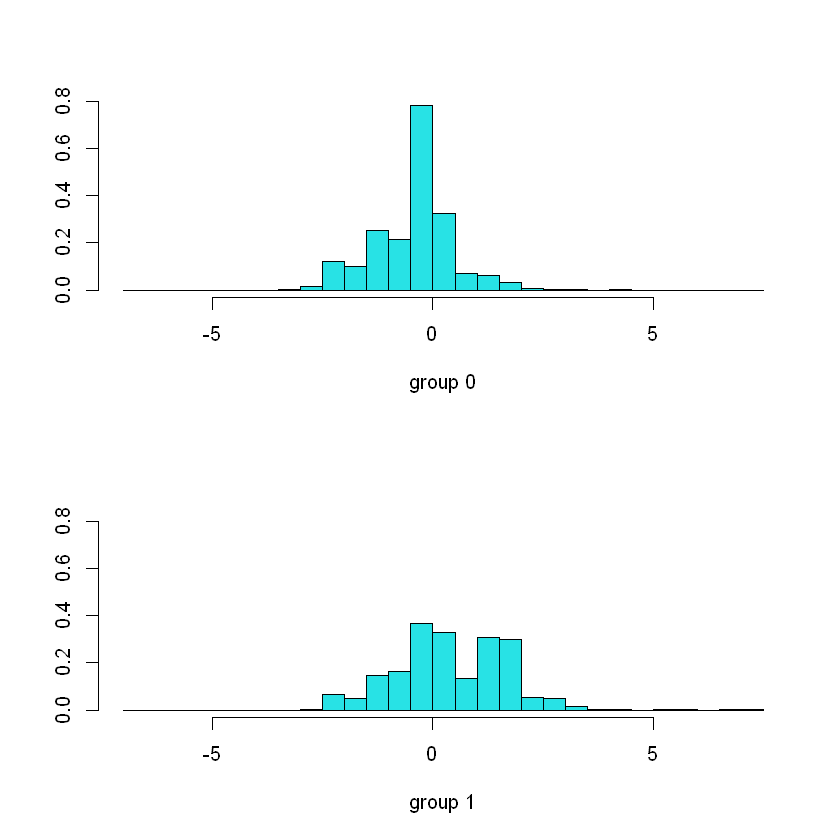

In [31]:
plot(lda)

In [32]:
# Make prediction on both train and test data
lda_pred_train <- predict(lda, newdata=train_df)

lda_pred_test <- predict(lda, newdata=test_df)

In [97]:
# Evaluation of model on train

# Confusion matrix
print('Confusion matrix:')
table(lda_pred_train$class, train_df$default)

# Accuracy
acc <- mean(lda_pred_train$class == train_df$default)
print(paste('Accuracy =', round(acc, 3), '%'))

# AUC
pred_auc <- pROC::auc(train_df$default,lda_pred_train$posterior[,2])
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


   
        0     1
  0 10622  2396
  1   280   702

[1] "Accuracy = 0.809 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.711926010460705"


In [98]:
# Evaluation of model on test

# Confusion matrix
print('Confusion matrix:')
table(lda_pred_test$class, test_df$default)

# Accuracy
acc <- mean(lda_pred_test$class == test_df$default)
print(paste('Accuracy =', round(acc, 3), '%'))

# AUC
pred_auc <- pROC::auc(test_df$default,lda_pred_test$posterior[,2])
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


   
       0    1
  0 4562 1040
  1  122  276

[1] "Accuracy = 0.806 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.708898997168139"


In [56]:
lda_pred_test$posterior [1:20,1]
lda_pred_test$class [1:20]

1         2         3         4         5         6         7         8 
0.7692310 0.7761535 0.9503178 0.7212697 0.4916011 0.8767264 0.4889267 0.9494929 
        9        10        11        12        13        14        15        16 
0.7934704 0.9100973 0.7444160 0.7533698 0.9022261 0.8793896 0.5048135 0.7760791 
       17        18        19        20 
0.7893662 0.8011868 0.9315196 0.6812782

[1] 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
Levels: 0 1

In [61]:
#change posterior probability to high threshold
sum(lda_pred_test$posterior[,2]>.9)

[1] 8

In [62]:
#change posterior probability to low threshold
sum(lda_pred_test$posterior[,2]>.2)

[1] 2936

In [63]:
#change posterior probability to low threshold
sum(lda_pred_test$posterior[,2]>.5)

[1] 398

## 3.3 Decision Tree

In [72]:
# Set up cross-validation
rdesc<-makeResampleDesc(method = "RepCV", folds=10, reps=5, stratify = T)


# Define the model
learner <- makeLearner("classif.rpart", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="credit", data=train_df, target="default")

In [73]:
#check available hyperparameters
getParamSet(learner)

                   Type len  Def   Constr Req Tunable Trafo
minsplit        integer   -   20 1 to Inf   -    TRUE     -
minbucket       integer   -    - 1 to Inf   -    TRUE     -
cp              numeric   - 0.01   0 to 1   -    TRUE     -
maxcompete      integer   -    4 0 to Inf   -    TRUE     -
maxsurrogate    integer   -    5 0 to Inf   -    TRUE     -
usesurrogate   discrete   -    2    0,1,2   -    TRUE     -
surrogatestyle discrete   -    0      0,1   -    TRUE     -
maxdepth        integer   -   30  1 to 30   -    TRUE     -
xval            integer   -   10 0 to Inf   -   FALSE     -
parms           untyped   -    -        -   -    TRUE     -

In [74]:
# Set hyper parameter tuning
tune_params <- makeParamSet(
    makeDiscreteParam('maxdepth', value=c(5, 10, 20)),
    makeDiscreteParam('minsplit', value=c(10, 20, 30))
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV

res <- tuneParams(learner, task=train_task, resampling=rdesc, par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    



[Tune] Started tuning learner classif.rpart for parameter set:

             Type len Def   Constr Req Tunable Trafo
maxdepth discrete   -   -  5,10,20   -    TRUE     -
minsplit discrete   -   - 10,20,30   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: maxdepth=5; minsplit=10

[Tune-y] 1: auc.test.mean=0.6399982; time: 0.0 min

[Tune-x] 2: maxdepth=10; minsplit=10

[Tune-y] 2: auc.test.mean=0.6399982; time: 0.1 min

[Tune-x] 3: maxdepth=20; minsplit=10

[Tune-y] 3: auc.test.mean=0.6399982; time: 0.1 min

[Tune-x] 4: maxdepth=5; minsplit=20

[Tune-y] 4: auc.test.mean=0.6399982; time: 0.0 min

[Tune-x] 5: maxdepth=10; minsplit=20

[Tune-y] 5: auc.test.mean=0.6399982; time: 0.1 min

[Tune-x] 6: maxdepth=20; minsplit=20

[Tune-y] 6: auc.test.mean=0.6399982; time: 0.1 min

[Tune-x] 7: maxdepth=5; minsplit=30

[Tune-y] 7: auc.test.mean=0.6399982; time: 0.0 min

[Tune-x] 8: maxdepth=10; minsplit=30

[Tune-y] 8: auc.test.mean=0.6399982; time: 0.1 min



In [75]:
res

Tune result:
Op. pars: maxdepth=5; minsplit=10
auc.test.mean=0.6399982

In [77]:
# Extract best model
dtbest_learner <- res$learner
    

In [78]:
# Retrain the model with tbe best hyper-parameters
dtbest_md <- mlr::train(dtbest_learner, train_task)
dtbest_md

Model for learner.id=classif.rpart; learner.class=classif.rpart
Trained on: task.id = credit; obs = 14000; features = 15
Hyperparameters: xval=0

In [79]:
# Summary the best model
summary(dtbest_md$learner.model)

Call:
rpart::rpart(formula = f, data = d, xval = 0)
  n= 14000 

         CP nsplit rel error
1 0.1762427      0 1.0000000
2 0.0100000      1 0.8237573

Variable importance
PAY_0 PAY_6 PAY_5 PAY_4 PAY_3 PAY_2 
   85     3     3     3     3     2 

Node number 1: 14000 observations,    complexity param=0.1762427
  predicted class=0  expected loss=0.2212857  P(node) =1
    class counts: 10902  3098
   probabilities: 0.779 0.221 
  left son=2 (12556 obs) right son=3 (1444 obs)
  Primary splits:
      PAY_0 < 1.5 to the left,  improve=704.6009, (0 missing)
      PAY_2 < 1.5 to the left,  improve=526.2861, (0 missing)
      PAY_3 < 1   to the left,  improve=403.0348, (0 missing)
      PAY_4 < 1   to the left,  improve=360.5310, (0 missing)
      PAY_5 < 1   to the left,  improve=339.2620, (0 missing)
  Surrogate splits:
      PAY_6 < 2.5 to the left,  agree=0.901, adj=0.039, (0 split)
      PAY_5 < 2.5 to the left,  agree=0.901, adj=0.038, (0 split)
      PAY_4 < 2.5 to the left,  agree=0.9

In [82]:
# Make prediction on test (holdout) data and train

dt_pred_train <- predict(dtbest_md, newdata=train_df)

dt_pred_test <- predict(dtbest_md, newdata=test_df)

In [95]:
# Evaluation of model on train


# Accuracy
acc <- mean(dt_pred_train$data$response == train_df$default)
print(paste('Accuracy =', round(acc, 3), '%'))


# AUC
pred_auc <- pROC::auc(train_df$default, dt_pred_train$data$prob.1)
print(paste('AUC =', pred_auc))

[1] "Accuracy = 0.818 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.63999492396548"


In [96]:
# Evaluation of model on test

# Accuracy
acc <- mean(dt_pred_test$data$response == test_df$default)
print(paste('Accuracy =', round(acc, 3), '%'))

# AUC
pred_auc <- pROC::auc(test_df$default, dt_pred_test$data$prob.1)
print(paste('AUC =', pred_auc))

[1] "Accuracy = 0.816 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.633059837667647"


## 3.4 Random Forest

In [45]:
# Set up cross-validation
rdesc = makeResampleDesc(method = "RepCV", folds=10, reps=5, stratify = T)

# Define the model
RF_learner<-makeLearner("classif.randomForest", predict.type="prob")

# Define the task
RF_task<-makeClassifTask(data=train_df, target = "default")

In [46]:
#check available hyperparameters
getParamSet(RF_learner)

                     Type  len   Def   Constr Req Tunable Trafo
ntree             integer    -   500 1 to Inf   -    TRUE     -
mtry              integer    -     - 1 to Inf   -    TRUE     -
replace           logical    -  TRUE        -   -    TRUE     -
classwt     numericvector <NA>     - 0 to Inf   -    TRUE     -
cutoff      numericvector <NA>     -   0 to 1   -    TRUE     -
strata            untyped    -     -        -   -   FALSE     -
sampsize    integervector <NA>     - 1 to Inf   -    TRUE     -
nodesize          integer    -     1 1 to Inf   -    TRUE     -
maxnodes          integer    -     - 1 to Inf   -    TRUE     -
importance        logical    - FALSE        -   -    TRUE     -
localImp          logical    - FALSE        -   -    TRUE     -
proximity         logical    - FALSE        -   -   FALSE     -
oob.prox          logical    -     -        -   Y   FALSE     -
norm.votes        logical    -  TRUE        -   -   FALSE     -
do.trace          logical    - FALSE    

In [47]:
# Set hyper parameter tuning
tune_params <- makeParamSet(makeIntegerParam("ntree", lower = 200, upper = 250), makeIntegerParam("mtry", lower = 3, upper = 5),
                        makeIntegerParam("maxnodes", lower = 5, upper = 7))

ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV

rf_res <- tuneParams(RF_learner, task=RF_task, resampling=rdesc, par.set=tune_params, control=ctrl, measures=list(mlr::auc))

[Tune] Started tuning learner classif.randomForest for parameter set:

            Type len Def     Constr Req Tunable Trafo
ntree    integer   -   - 200 to 250   -    TRUE     -
mtry     integer   -   -     3 to 5   -    TRUE     -
maxnodes integer   -   -     5 to 7   -    TRUE     -

With control class: TuneControlGrid

Imputation value: -0

[Tune-x] 1: ntree=200; mtry=3; maxnodes=5

[Tune-y] 1: auc.test.mean=0.7202643; time: 0.8 min

[Tune-x] 2: ntree=206; mtry=3; maxnodes=5

[Tune-y] 2: auc.test.mean=0.7216541; time: 0.8 min

[Tune-x] 3: ntree=211; mtry=3; maxnodes=5

[Tune-y] 3: auc.test.mean=0.7207422; time: 0.8 min

[Tune-x] 4: ntree=217; mtry=3; maxnodes=5

[Tune-y] 4: auc.test.mean=0.7209712; time: 0.8 min

[Tune-x] 5: ntree=222; mtry=3; maxnodes=5

[Tune-y] 5: auc.test.mean=0.7218617; time: 0.9 min

[Tune-x] 6: ntree=228; mtry=3; maxnodes=5

[Tune-y] 6: auc.test.mean=0.7212773; time: 0.9 min

[Tune-x] 7: ntree=233; mtry=3; maxnodes=5

[Tune-y] 7: auc.test.mean=0.7212305; tim

[Tune-y] 82: auc.test.mean=0.7153178; time: 0.9 min

[Tune-x] 83: ntree=211; mtry=5; maxnodes=7

[Tune-y] 83: auc.test.mean=0.7154383; time: 0.9 min

[Tune-x] 84: ntree=217; mtry=5; maxnodes=7

[Tune-y] 84: auc.test.mean=0.7149876; time: 1.0 min

[Tune-x] 85: ntree=222; mtry=5; maxnodes=7

[Tune-y] 85: auc.test.mean=0.7152844; time: 1.0 min

[Tune-x] 86: ntree=228; mtry=5; maxnodes=7

[Tune-y] 86: auc.test.mean=0.7150175; time: 1.0 min

[Tune-x] 87: ntree=233; mtry=5; maxnodes=7

[Tune-y] 87: auc.test.mean=0.7162145; time: 1.0 min

[Tune-x] 88: ntree=239; mtry=5; maxnodes=7

[Tune-y] 88: auc.test.mean=0.7149205; time: 1.1 min

[Tune-x] 89: ntree=244; mtry=5; maxnodes=7

[Tune-y] 89: auc.test.mean=0.7161357; time: 1.1 min

[Tune-x] 90: ntree=250; mtry=5; maxnodes=7

[Tune-y] 90: auc.test.mean=0.7158715; time: 1.1 min

[Tune] Result: ntree=222; mtry=3; maxnodes=5 : auc.test.mean=0.7218617



In [48]:
rf_res

Tune result:
Op. pars: ntree=222; mtry=3; maxnodes=5
auc.test.mean=0.7218617

In [99]:
# Extract best model
best_learner <- rf_res$learner

In [100]:
# Retrain the model with the best hyper-parameters
best_md <- mlr::train(best_learner, RF_task)
best_md

Model for learner.id=classif.randomForest; learner.class=classif.randomForest
Trained on: task.id = train_df; obs = 14000; features = 15
Hyperparameters: 

In [101]:
best_md$learner.model


Call:
 randomForest(formula = f, data = data, classwt = classwt, cutoff = cutoff) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 18.52%
Confusion matrix:
      0    1 class.error
0 10283  619  0.05677857
1  1974 1124  0.63718528

In [102]:
# Make prediction on test (holdout) data and train

rf_pred_test <- predict(best_md, newdata=test_df)

rf_pred_train <- predict(best_md, newdata=train_df)

In [104]:
# Evaluation of model on train 

# Accuracy
acc <- mean(rf_pred_train$data$response == train_df$default)
print(paste('Accuracy =', round(acc, 3), '%'))


#AUC
pred_auc <- pROC::auc(train_df$default, rf_pred_train$data$prob.1)
print(paste('AUC =', pred_auc))

[1] "Accuracy = 0.985 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.992971598959164"


In [105]:
# Evaluation of model on test

#Accuracy
acc <- mean(rf_pred_test$data$response == test_df$default)
print(paste('Accuracy =', round(acc, 3), '%'))


#AUC
pred_auc <- pROC::auc(test_df$default, rf_pred_test$data$prob.1)
print(paste('AUC =', pred_auc))

[1] "Accuracy = 0.809 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.738951426183425"


In [70]:
importance(best_md$learner.model)

,MeanDecreaseGini
LIMIT_BAL,407.33735
PAY_0,488.51571
PAY_2,247.26653
PAY_3,179.87602
PAY_4,151.39893
PAY_5,134.97748
PAY_6,136.22013
PAY_AMT1,446.04080
PAY_AMT2,430.59211
PAY_AMT3,410.84620


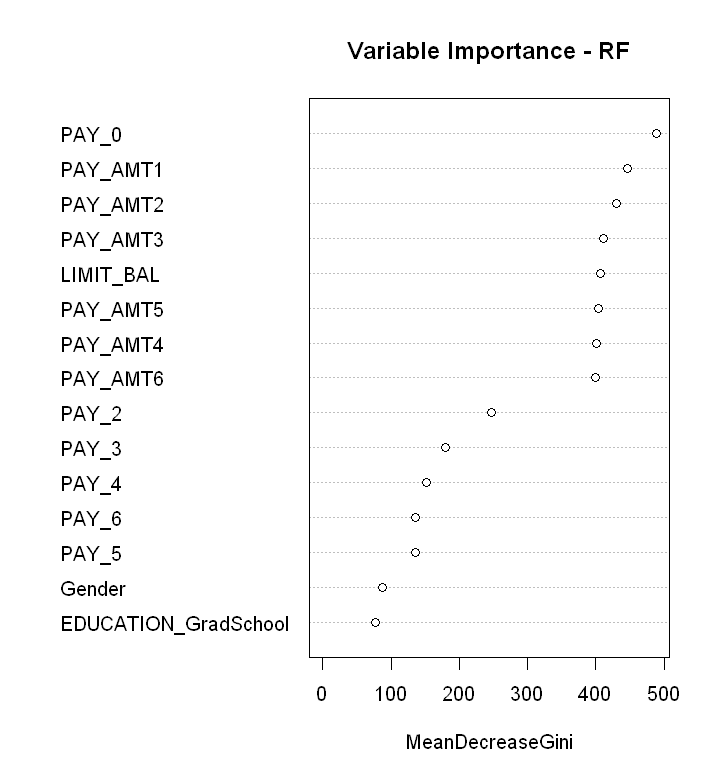

In [71]:
# Plot feature importance
options(repr.plot.width=6, repr.plot.height=6.5)
varImpPlot(best_md$learner.model, type=2, main='Variable Importance - RF')

## 3.5 Support Vector Machines

In [28]:
train_df$default <-as.factor(train_df$default)
test_df$default <-as.factor(test_df$default)

In [27]:
#fit the model using cross validation for tuning cost and gamma 
# non linear kernel

set.seed(1)
tune_svm <- tune(svm, default ~ ., data=train_df, kernel='radial',
                 ranges=list(cost=c(0.1, 1),  # List of cost values
                 gamma=c(0.5, 1)))  # List of gamma values

In [28]:
# Summary tuned models
summary(tune_svm)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    1   0.5

- best performance: 0.1906429 

- Detailed performance results:
  cost gamma     error  dispersion
1  0.1   0.5 0.2050714 0.007295589
2  1.0   0.5 0.1906429 0.007652086
3  0.1   1.0 0.2110714 0.009148870
4  1.0   1.0 0.1976429 0.008902661


In [29]:
# Retrain the model with the best hyper-parameters

svm <- svm( default ~ ., data=train_df, kernal='radial', gamma=0.5, cost=1, probability=TRUE)

In [30]:
# Make prediction on test (holdout) data and train
svm_pred_test <- predict(svm, newdata=test_df, probability=TRUE)

svm_pred_train <- predict(svm, newdata=train_df, probability=TRUE)

In [40]:
trainprobs <- attr(svm_pred_train, "probabilities")

In [41]:
testprobs <- attr(svm_pred_test, "probabilities")

In [42]:
head(testprobs)

,0,1
1,0.8575639,0.1424361
2,0.8458220,0.1541780
3,0.8458275,0.1541725
4,0.7257370,0.2742630
5,0.8284029,0.1715971
6,0.8457935,0.1542065


In [32]:
svm_pred_test

1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
   0    0    0    0    0    0    0    0    0    0    0    1    0    0    0    0 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
   0    1    0    1    0    0    0    0    0    0    0    0    0    0    0    0 
  49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64 
   0    0    0    0    0    0    1    0    0    0    0    0    1    0    0    0 
  65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80 
   0    0    0    0    0    0    0    0    0    0    0    0    0    1    0    1 
  81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
  97   98   99  100  101  102  103  104  105  106  107  108  109  110  111  112 
   1    0    0    0    1    0    0    0    0    0    0    1    0    0    0    0 
 113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128 
   0    0    0    0    0    0    0    1    0    0    0    0    0    0    0    0 
 129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
 145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160 
   1    1    0    0    1    0    0    0    0    0    0    1    0    0    0    0 
 161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176 
   0    0    0    0    0    0    0    0    0    0    1    0    0    0    0    0 
 177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192 
   0    0    0    0    0    0    0    0    1    0    0    1    0    0    0    1 
 193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208 
   1    0    0    0    0    0    1    0    0    0    0    0    0    1    0    0 
 209  210  211  212  213  214  215  216  217  218  219  220  221  222  223  224 
   0    0    0    0    0    0    0    1    1    0    0    1    0    0    0    0 
 225  226  227  228  229  230  231  232  233  234  235  236  237  238  239  240 
   0    0    0    0    0    0    1    0    0    0    0    0    0    0    1    0 
 241  242  243  244  245  246  247  248  249  250  251  252  253  254  255  256 
   0    0    0    0    0    0    0    0    0    0    0    0    1    0    0    1 
 257  258  259  260  261  262  263  264  265  266  267  268  269  270  271  272 
   0    0    0    0    0    1    0    0    0    0    0    0    0    0    0    0 
 273  274  275  276  277  278  279  280  281  282  283  284  285  286  287  288 
   0    0    0    0    0    0    0    1    0    0    0    0    0    0    0    0 
 289  290  291  292  293  294  295  296  297  298  299  300  301  302  303  304 
   0    0    1    0    0    0    0    0    0    1    0    0    0    0    0    0 
 305  306  307  308  309  310  311  312  313  314  315  316  317  318  319  320 
   0    0    0    1    0    0    0    0    0    0    0    0    0    0    1    0 
 321  322  323  324  325  326  327  328  329  330  331  332  333  334  335  336 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
 337  338  339  340  341  342  343  344  345  346  347  348  349  350  351  352 
   0    0    0    0    0    0    0    0    0    0    0    0    0    1    0    1 
 353  354  355  356  357  358  359  360  361  362  363  364  365  366  367  368 
   0    1    0    0    0    0    0    0    1    0    0    0    0    0    0    0 
 369  370  371  372  373  374  375  376  377  378  379  380  381  382  383  384 
   0    1    0    0    0    1    0    1    0    0    0    0    0    0    0    0 
 385  386  387  388  389  390  391  392  393  394  395  396  397  398  399  400 
   1    0    0    0    0    0    0

In [43]:
# Evaluation of model on train 

# Accuracy
acc <- mean(svm_pred_train == train_df$default)
print(paste('Accuracy =', round(acc, 3), '%'))


#AUC
pred_auc <- pROC::auc(train_df$default, trainprobs[,2])
print(paste('AUC =', pred_auc))

[1] "Accuracy = 0.845 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.872822596146501"


In [44]:
# Evaluation of model on test

# Accuracy
acc <- mean(svm_pred_test == test_df$default)
print(paste('Accuracy =', round(acc, 3), '%'))


#AUC
pred_auc <- pROC::auc(test_df$default, testprobs[,2])
print(paste('AUC =', pred_auc))

[1] "Accuracy = 0.809 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.678154582371859"
